In [1]:
# dgl安装命令：
# !pip install dgl-2.0.0-cp39-cp39-win_amd64.whl

In [2]:
import dgl
import torch
import torch.nn as nn
import dgl.nn as dglnn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
import import_ipynb
from util import utils

# 图数据加载

In [3]:
# 加载Cora数据集
data = dgl.data.CoraGraphDataset()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [4]:
# 查看图的基本信息
graph = data[0]
features = graph.ndata['feat']
labels = graph.ndata['label']
in_features = features.shape[1]
num_classes = data.num_classes 
num_nodes = graph.num_nodes()
num_edges = graph.num_edges()
print(in_features, num_classes, num_nodes, num_edges)

1433 7 2708 10556


# 定义图神经网络模型

## GCN

In [6]:
class GCN(nn.Module):
    
    def __init__(self, in_features, hidden_features, out_features):
        super(GCN,self).__init__()
        torch.manual_seed(1234567)
        self.conv1 = dglnn.GraphConv(in_features, hidden_features)
        self.conv2 = dglnn.GraphConv(hidden_features, out_features)
        
    def forward(self, graph, features):
        x = self.conv1(graph, features)
        x = torch.relu(x)
        x = self.conv2(graph, x)
        return x

# 初始化

In [8]:
hidden_features = 32

In [9]:
model = GCN(in_features, hidden_features, num_classes)

# 可视化分析（训练前）

## 绘制混淆矩阵

In [ ]:
def show_confusion_matrix(model, graph, features, labels):
    output = model(graph, features)
    _, pred = torch.max(output, 1)
    cm = confusion_matrix(labels, pred)
    print("Confusion Matrix:")
    print(cm)

In [10]:
show_confusion_matrix(model, graph, features, labels)

Confusion Matrix:
[[ 29 267   1  35   1  17   1]
 [ 12 185   0   4   0   8   8]
 [ 11 218   3  11   1  10 164]
 [ 75 564   1  87   4  57  30]
 [ 27 302   0  45   4  37  11]
 [ 43 194   0  32   0  17  12]
 [  6 111   0  32   0  22   9]]


# 模型训练

## 训练过程

In [11]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [12]:
num_epochs = 200

In [13]:
def train(model, graph, features, criterion, optimizer, labels):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(graph, features)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {loss.item()}') 
    return train_losses

In [14]:
train_losses = train(model, graph, features, criterion, optimizer, labels)

Epoch 10, Train Loss: 1.765895962715149
Epoch 20, Train Loss: 1.567604422569275
Epoch 30, Train Loss: 1.2953604459762573
Epoch 40, Train Loss: 0.9958522319793701
Epoch 50, Train Loss: 0.7280400395393372
Epoch 60, Train Loss: 0.5351551175117493
Epoch 70, Train Loss: 0.411327987909317
Epoch 80, Train Loss: 0.3344149589538574
Epoch 90, Train Loss: 0.28502312302589417
Epoch 100, Train Loss: 0.2505844235420227
Epoch 110, Train Loss: 0.22455959022045135
Epoch 120, Train Loss: 0.20372025668621063
Epoch 130, Train Loss: 0.18640819191932678
Epoch 140, Train Loss: 0.17166943848133087
Epoch 150, Train Loss: 0.15895859897136688
Epoch 160, Train Loss: 0.14787784218788147
Epoch 170, Train Loss: 0.13811320066452026
Epoch 180, Train Loss: 0.12943410873413086
Epoch 190, Train Loss: 0.12167162448167801
Epoch 200, Train Loss: 0.11469440907239914


## 绘制训练曲线

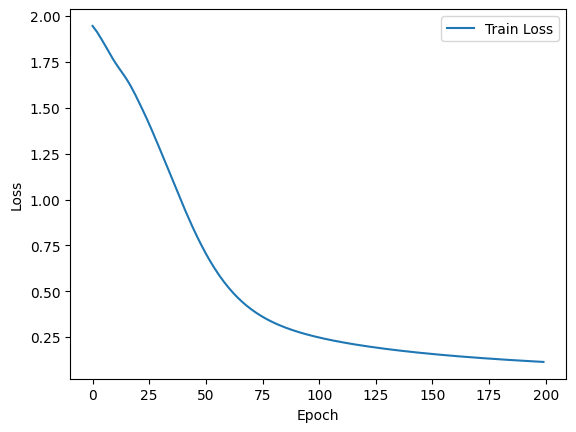

In [15]:
utils.show_train_loss(train_losses)

# 模型测试

In [16]:
def test(model, graph, features, labels):
    model.eval()
    with torch.no_grad():
        output = model(graph, features)
        _, pred = torch.max(output, 1)
        accuracy = (pred==labels).sum().item() / len(labels) 
    return accuracy

In [17]:
accuracy = test(model, graph, features, labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9704579025110783


# 可视化分析（训练后）

## 绘制混淆矩阵

In [19]:
show_confusion_matrix(model, graph, features, labels)

Confusion Matrix:
[[337   1   1   5   1   5   1]
 [  1 209   3   2   1   1   0]
 [  0   1 415   2   0   0   0]
 [  6   2   2 800   5   3   0]
 [  4   1   0   9 412   0   0]
 [  4   1   3   1   2 283   4]
 [  3   0   0   0   0   5 172]]
